# Centering script

In [17]:
# Basics
import numpy as np
import pandas as pd
import os

# Scipy
from scipy import optimize
from scipy.ndimage import gaussian_filter
#from sklearn.neighbors import KDTree
from scipy import stats

# Plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator, AutoLocator, MaxNLocator
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import Colorbar
import matplotlib.colors as mcolors
from matplotlib import colors
import matplotlib.ticker as ticker
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D

# RC params
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14
rcParams["axes.edgecolor"] = 'black'
rcParams["legend.edgecolor"] = '0.8'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

## Correct model to run

In [2]:
model_path = "/Users/maddie/Desktop/Thesis/Simulation_output/K_Magellan/runw46"
os.chdir(model_path)

## Start with only the original iwas location

In [18]:
col_header = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'iwas', 'id', 'mass']

old = np.load('old.npy') # Need old to get iwas
iwas4 = [old[0,0], old[0,1], old[0,2]]
#iwas4 = [-33.7673, 444.823, -18.1474] #Centered using other script

old = pd.DataFrame(old, columns=col_header)


new = np.load('new.npy')
new = pd.DataFrame(new, columns=col_header)

In [30]:
gal = np.load('gal.npy')
gal = pd.DataFrame(gal, columns=col_header)

gas = np.load('gas.npy')
gas = pd.DataFrame(gas, columns=col_header)


In [19]:
old = old.assign(x_scale = old.x - iwas4[0])
old = old.assign(y_scale = old.y - iwas4[1])
old = old.assign(z_scale = old.z - iwas4[2])

new = new.assign(x_scale = new.x - iwas4[0])
new = new.assign(y_scale = new.y - iwas4[1])
new = new.assign(z_scale = new.z - iwas4[2])



In [6]:
v_init = np.sqrt(np.average(old.vx)**2 + np.average(old.vy)**2)
print(v_init)
print(np.average(old.vx))
print(np.average(old.vy))
print(np.average(old.vz))

26.07370167601059
-25.79938126995052
-3.772246701545886
-0.24653083343312573


In [24]:
i = 10 # get within 5 pc
old_crop = old.loc[(old.y_scale<i)&(old.y_scale>-i)&(old.x_scale<i)&(old.x_scale>-i)&(old.z_scale<i)&(old.z_scale>-i)]
new_crop = new.loc[(new.y_scale<i)&(new.y_scale>-i)&(new.x_scale<i)&(new.x_scale>-i)&(new.z_scale<i)&(new.z_scale>-i)]


### Changing directory to new folder

In [8]:
path = "centering_output"
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s" % path)
    
    
os.chdir(path)

Creation of the directory centering_output failed


#### The COM will be influenced by the position of the new stars
- this should be taken into account by performing the KDE on both the old and new stars
seeing as the new stars are so turbulent and unsettled, just use the old stars - going to be easier to find the maximum

## Check current position

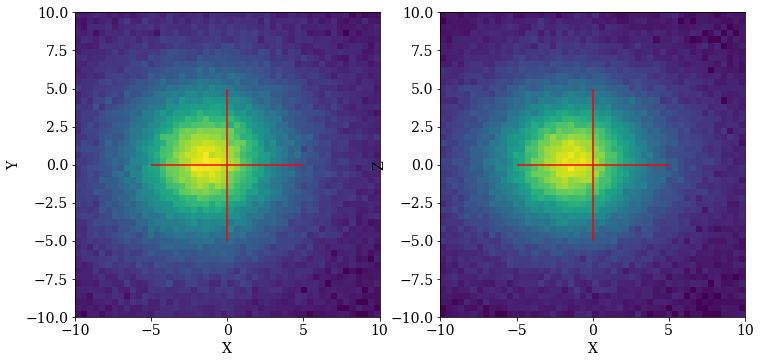

In [9]:
rang = i
# previous -> bins = rang*2
bin_size = 50
gamma = 0.5

old_bin1, xedges, yedges = np.histogram2d(old_crop.x_scale, old_crop.y_scale, bins = bin_size, weights = old_crop.mass, range=([-rang,rang],[-rang,rang]))
old_bin2, xedges, yedges = np.histogram2d(old_crop.x_scale, old_crop.z_scale, bins = bin_size, weights = old_crop.mass, range=([-rang,rang],[-rang,rang]))

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)
ax[0].imshow(old_bin1.T, norm=mcolors.PowerNorm(gamma), 
             origin='lower', extent=[-rang, rang, -rang, rang])
ax[0].hlines(0,-5,5, 'r')
ax[0].vlines(0,-5,5, 'r')
ax[0].set_ylabel('Y')
ax[0].set_xlabel('X')

ax[1].imshow(old_bin2.T, norm=mcolors.PowerNorm(gamma), 
             origin='lower', extent=[-rang, rang, -rang, rang])
ax[1].hlines(0,-5,5, 'r')
ax[1].vlines(0,-5,5, 'r')
ax[1].set_ylabel('Z')
ax[1].set_xlabel('X')

plt.savefig('original_centering')
plt.show()

## Perform Kernal Density Estimation

In [21]:
xyz = np.vstack([old_crop.x_scale, old_crop.y_scale, old_crop.z_scale])
kde = stats.gaussian_kde(xyz, weights = old_crop.mass, bw_method = 'silverman')
density = kde(xyz)
np.save("kde", density)

In [22]:
max_density = np.argmax(density)
max_dense_x = old_crop.x_scale.iloc[max_density]
max_dense_y = old_crop.y_scale.iloc[max_density]
max_dense_z = old_crop.z_scale.iloc[max_density]

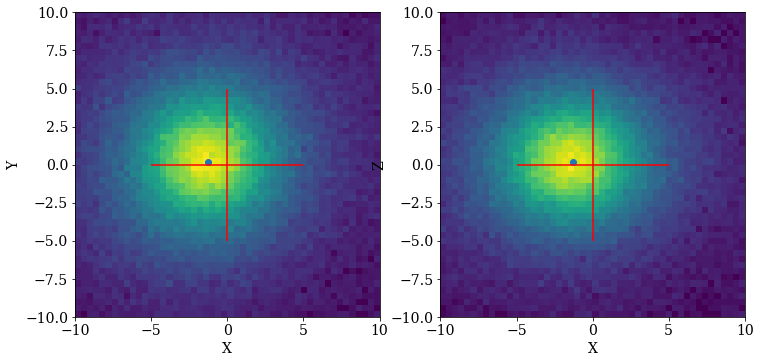

In [12]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)
ax[0].imshow(old_bin1.T, norm=mcolors.PowerNorm(gamma), 
             origin='lower', extent=[-rang, rang, -rang, rang])
ax[0].scatter(max_dense_x,max_dense_y)
ax[0].hlines(0,-5,5, 'r')
ax[0].vlines(0,-5,5, 'r')
ax[0].set_ylabel('Y')
ax[0].set_xlabel('X')

ax[1].imshow(old_bin2.T, norm=mcolors.PowerNorm(gamma), 
             origin='lower', extent=[-rang, rang, -rang, rang])
ax[1].scatter(max_dense_x, max_dense_z)
ax[1].hlines(0,-5,5, 'r')
ax[1].vlines(0,-5,5, 'r')
ax[1].set_ylabel('Z')
ax[1].set_xlabel('X')


plt.savefig('KDE_estimation')

plt.show()

In [13]:
old = old.assign(x_scale = old.x - max_dense_x - iwas4[0])
old = old.assign(y_scale = old.y - max_dense_y - iwas4[1])
old = old.assign(z_scale = old.z - max_dense_z - iwas4[2])

new = new.assign(x_scale = new.x - max_dense_x - iwas4[0])
new = new.assign(y_scale = new.y - max_dense_y - iwas4[1])
new = new.assign(z_scale = new.z - max_dense_z - iwas4[2])

## Final result

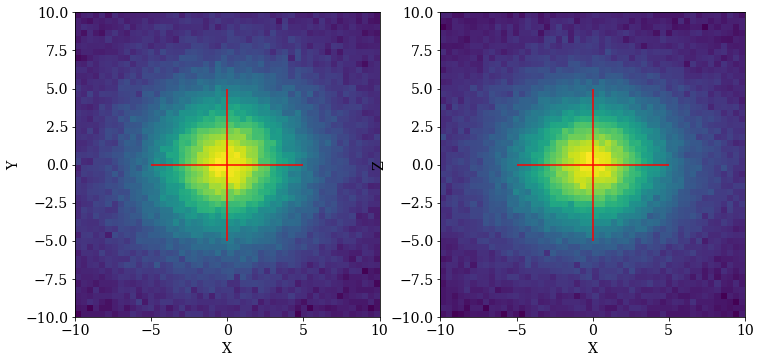

In [14]:
old_bin1, xedges, yedges = np.histogram2d(old.x_scale, old.y_scale, bins = bin_size, weights = old.mass, range=([-rang,rang],[-rang,rang]))
old_bin2, xedges, yedges = np.histogram2d(old.x_scale, old.z_scale, bins = bin_size, weights = old.mass, range=([-rang,rang],[-rang,rang]))

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)
ax[0].imshow(old_bin1.T, norm=mcolors.PowerNorm(gamma), 
             origin='lower', extent=[-rang, rang, -rang, rang])
ax[0].hlines(0,-5,5, 'r')
ax[0].vlines(0,-5,5, 'r')
ax[0].set_ylabel('Y')
ax[0].set_xlabel('X')

ax[1].imshow(old_bin2.T, norm=mcolors.PowerNorm(gamma), 
             origin='lower', extent=[-rang, rang, -rang, rang])
ax[1].hlines(0,-5,5, 'r')
ax[1].vlines(0,-5,5, 'r')
ax[1].set_ylabel('Z')
ax[1].set_xlabel('X')

plt.savefig('after_centering')
plt.show()

In [26]:
old = old.assign(r = np.power(np.power(old.x_scale,2) + np.power(old.y_scale,2) + np.power(old.z_scale,2), 0.5))
new = new.assign(r = np.power(np.power(new.x_scale,2) + np.power(new.y_scale,2) + np.power(new.z_scale,2), 0.5))

In [22]:
print('old < 5:',  np.sum(old.loc[old.r < 5].mass))
print('old < 10:', np.sum(old.loc[old.r < 10].mass))
print('old < 20: ', np.sum(old.loc[old.r < 20].mass))

print('new < 5:',  np.sum(new.loc[new.r < 5].mass))
print('new < 10:', np.sum(new.loc[new.r < 10].mass))
print('new < 20: ', np.sum(new.loc[new.r < 20].mass))

old < 5: 396033.9
old < 10: 646674.2
old < 20:  736886.25
new < 5: 434915.27603
new < 10: 1098008.45222
new < 20:  2189765.9793000002


In [31]:
gal = gal.assign(x_scale = gal.x - max_dense_x - iwas4[0])
gal = gal.assign(y_scale = gal.y - max_dense_y - iwas4[1])
gal = gal.assign(z_scale = gal.z - max_dense_z - iwas4[2])

gas = gas.assign(x_scale = gas.x - max_dense_x - iwas4[0])
gas = gas.assign(y_scale = gas.y - max_dense_y - iwas4[1])
gas = gas.assign(z_scale = gas.z - max_dense_z - iwas4[2])

gal = gal.assign(r = np.power(np.power(gal.x_scale,2) + np.power(gal.y_scale,2) + np.power(gal.z_scale,2), 0.5))
gas = gas.assign(r = np.power(np.power(gas.x_scale,2) + np.power(gas.y_scale,2) + np.power(gas.z_scale,2), 0.5))

In [46]:
print('gas < 5:',  np.sum(gas.loc[gas.r < 5].mass))
print('gas < 10:', np.sum(gas.loc[gas.r < 10].mass))
print('gas < 20: ', np.sum(gas.loc[gas.r < 20].mass))

print('gal < 5:',  np.sum(gal.loc[gal.r < 5].mass))
print('gal < 10:', np.sum(gal.loc[gal.r < 10].mass))
print('gal < 20: ', np.sum(gal.loc[gal.r < 20].mass))
print('gal < 30: ', np.sum(gal.loc[gal.r < 30].mass))

gas < 5: 20359.96617
gas < 10: 107665.35983
gas < 20:  185046.59922000003
gal < 5: 1440.0
gal < 10: 10440.0
gal < 20:  58680.0
gal < 30:  143820.0


In [49]:
(np.sum(new.loc[new.r < 20].mass) + np.sum(old.loc[old.r < 20].mass) + np.sum(gal.loc[gal.r < 50].mass))/(np.sum(new.loc[new.r < 20].mass)+ np.sum(old.loc[old.r < 20].mass))* 100


112.87272864976201

In [40]:
v_median = [np.mean(old_crop.vx), np.mean(old_crop.vy), np.mean(old_crop.vz)]

In [41]:
new = new.assign(vx_scale = new.vx - v_median[0])
new = new.assign(vy_scale = new.vy - v_median[1])
new = new.assign(vz_scale = new.vz - v_median[2])

old = old.assign(vx_scale = old.vx - v_median[0])
old = old.assign(vy_scale = old.vy - v_median[1])
old = old.assign(vz_scale = old.vz - v_median[2])

In [45]:
print('vx: ', np.average(old.loc[old.r < 20].vx_scale))
print('vy: ', np.average(old.loc[old.r < 20].vy_scale))
print('vz: ', np.average(old.loc[old.r < 20].vz_scale))

print('vx: ', np.average(new.loc[new.r < 20].vx_scale))
print('vy: ', np.average(new.loc[new.r < 20].vy_scale))
print('vz: ', np.average(new.loc[new.r < 20].vz_scale))

vx:  -0.07563836576645655
vy:  0.00966970409741894
vz:  0.022306761417603817
vx:  0.9640339672351693
vy:  1.2666691016633533
vz:  0.10174774646250273


In [3]:
model_path = "/Users/maddie/Desktop/Thesis/Simulation_output/K_Magellan/runw46"
os.chdir(model_path)


In [4]:
col_header = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'iwas', 'id', 'mass']
old_i = np.load('old0.npy') # Need old to get iwas
iwas4 = [old_i[0,0], old_i[0,1], old_i[0,2]]
#iwas4 = [-33.7673, 444.823, -18.1474] #Centered using other script

old_i = pd.DataFrame(old_i, columns=col_header)



In [5]:
old_i = old_i.assign(x_scale = old_i.x - iwas4[0])
old_i = old_i.assign(y_scale = old_i.y - iwas4[1])
old_i = old_i.assign(z_scale = old_i.z - iwas4[2])

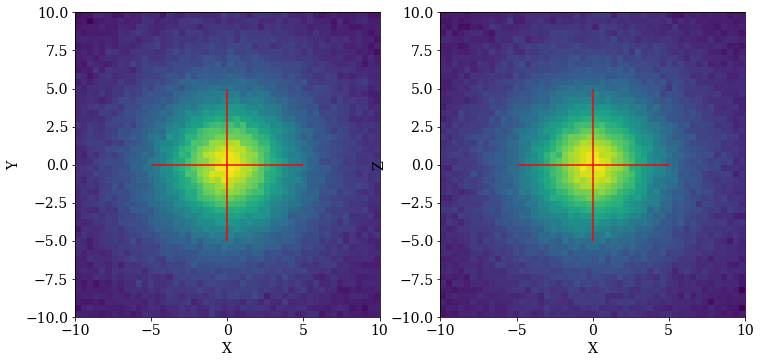

In [33]:
i = 10 # get within 5 pc
rang = i
# previous -> bins = rang*2
bin_size = 50
gamma = 0.5

old_bin1, xedges, yedges = np.histogram2d(old_i.x_scale, old_i.y_scale, bins = bin_size, weights = old_i.mass, range=([-rang,rang],[-rang,rang]))
old_bin2, xedges, yedges = np.histogram2d(old_i.x_scale, old_i.z_scale, bins = bin_size, weights = old_i.mass, range=([-rang,rang],[-rang,rang]))

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)
ax[0].imshow(old_bin1.T, norm=mcolors.PowerNorm(gamma), 
             origin='lower', extent=[-rang, rang, -rang, rang])
ax[0].hlines(0,-5,5, 'r')
ax[0].vlines(0,-5,5, 'r')
ax[0].set_ylabel('Y')
ax[0].set_xlabel('X')

ax[1].imshow(old_bin2.T, norm=mcolors.PowerNorm(gamma), 
             origin='lower', extent=[-rang, rang, -rang, rang])
ax[1].hlines(0,-5,5, 'r')
ax[1].vlines(0,-5,5, 'r')
ax[1].set_ylabel('Z')
ax[1].set_xlabel('X')

plt.savefig('after_centering')
plt.show()

In [8]:
old_i = old_i.assign(r = np.power(np.power(old_i.x_scale,2) + np.power(old_i.y_scale,2) + np.power(old_i.z_scale,2), 0.5))

In [9]:
print('old < 5:',  np.sum(old_i.loc[old_i.r < 5].mass))
print('old < 10:', np.sum(old_i.loc[old_i.r < 10].mass))
print('old < 20: ', np.sum(old_i.loc[old_i.r < 100].mass))

old < 5: 507365.0
old < 10: 850660.0
old < 20:  1000000.0


In [12]:
old = old_i
new = old_i

In [27]:
# Take the best estmate of the clusters mean velosity as that of the 1G within 10 pc
old_10  = old.loc[old.r<10]

vx_scale = np.mean(old_10.vx)
vy_scale = np.mean(old_10.vy)
vz_scale = np.mean(old_10.vz)

old = old.assign(vx_scale = old.vx - vx_scale)
old = old.assign(vy_scale = old.vy - vy_scale)
old = old.assign(vz_scale = old.vz - vz_scale)

new = new.assign(vx_scale = new.vx - vx_scale)
new = new.assign(vy_scale = new.vy - vy_scale)
new = new.assign(vz_scale = new.vz - vz_scale)

average new vx std 6.0528296370827395
average new vy std 5.095949043108126
average new vz std 2.4622222502763855
average old vx std 10.955960571316801
average old vy std 11.013276847111666
average old vz std 10.786717874429801
-1.5823754673984107 -1.6586706149315789 0.044049094492229865 -8.412099289507047 -6.665537896187985 0.43322004569776507


TypeError: 'NoneType' object is not iterable

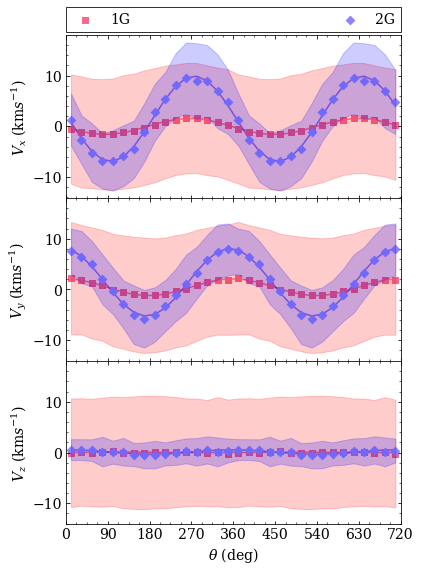

In [35]:
new_col = 'xkcd:periwinkle'
old_col = 'xkcd:rosy pink'

old_vx = 0
old_vy = 0
old_vz = 0

new_vx = 0
new_vy = 0
new_vz = 0


def get_theta(arr):
    angles = np.arctan2(arr['y_scale'],arr['x_scale'])
    angles = (2*np.pi + angles) * (angles < 0) + angles*(angles > 0)
    arr = arr.assign(theta = angles)

    return arr

def get_angles_arr():
    # because its gross and ugly and I want to hide my hard coding shame
    return [0, 0.39269908169872414, 0.7853981633974483, 1.1780972450961724, 1.5707963267948966, 
            1.9634954084936207, 2.356194490192345, 2.748893571891069, 3.141592653589793, 3.5342917352885173, 
            3.9269908169872414, 4.319689898685965, 4.71238898038469, 5.105088062083414, 5.497787143782138, 
            5.890486225480862, 6.283185307179586]

def polar_split(arr_ns, arr_gc):
    arr_ns = get_theta(arr_ns)
    arr_gc = get_theta(arr_gc)
   


    # Hard code in array bounds - not going to change at any point (always 16 slices)
    angles_arr = get_angles_arr()

    gc_vy = []    # empty list to append average vy values to
    gc_vz = []
    gc_vx = []

    gc_vy_std = []    # empty list to append average vy values to
    gc_vz_std = []
    gc_vx_std = []

    ns_vy = []
    ns_vz = []
    ns_vx = []

    ns_vy_std = []
    ns_vz_std = []
    ns_vx_std = []
    
    for i in range(1, 17): # For indexing the angles array
        temp_ns = arr_ns.loc[ (arr_ns['theta'] < angles_arr[i]) & (arr_ns['theta'] > angles_arr[i-1]) ]
        temp_gc = arr_gc.loc[ (arr_gc['theta'] < angles_arr[i]) & (arr_gc['theta'] > angles_arr[i-1]) ]

        gc_vy.append(temp_gc['vy_scale'].mean())
        gc_vz.append(temp_gc['vz_scale'].mean())
        gc_vx.append(temp_gc['vx_scale'].mean())

        ns_vy.append(temp_ns['vy_scale'].mean())
        ns_vz.append(temp_ns['vz_scale'].mean())
        ns_vx.append(temp_ns['vx_scale'].mean())


        gc_vy_std.append(temp_gc['vy_scale'].std())
        gc_vz_std.append(temp_gc['vz_scale'].std())
        gc_vx_std.append(temp_gc['vx_scale'].std())

        ns_vy_std.append(temp_ns['vy_scale'].std())
        ns_vz_std.append(temp_ns['vz_scale'].std())
        ns_vx_std.append(temp_ns['vx_scale'].std())

    v_av_vals = pd.DataFrame({'gc_vy':gc_vy, 'gc_vz':gc_vz, 'gc_vx':gc_vx, 'ns_vy':ns_vy, 'ns_vz':ns_vz, 'ns_vx':ns_vx, 'gc_vy_std':gc_vy_std, 'gc_vz_std':gc_vz_std, 'gc_vx_std':gc_vx_std, 'ns_vy_std':ns_vy_std, 'ns_vz_std':ns_vz_std, 'ns_vx_std':ns_vx_std})
    
    
    return v_av_vals

def get_cartesian_points(rad_val):
    angles_arr = get_angles_arr()
    angles_arr = np.delete(angles_arr, 0) # delete the 0 at the beginning
    mid_angle = 2* np.pi/32

    mid_angle_arr = angles_arr - mid_angle

    x_rad = rad_val * np.cos(mid_angle_arr)
    y_rad = rad_val * np.sin(mid_angle_arr)

    return x_rad, y_rad

def sine_fit(x, a, b, c, d):
    return a * np.sin(b * x +c)+d

def rot_theta__overlay_plot(theta, rot_arr):

    # Use graphics grid to put legend into its own axis
    params_gcx, params_covariance = optimize.curve_fit(sine_fit, theta, rot_arr.gc_vx, p0=[10, 0.017, 0, 0])
    params_gcy, params_covariance = optimize.curve_fit(sine_fit, theta, rot_arr.gc_vy, p0=[10, 0.017, 0, 0])
    params_gcz, params_covariance = optimize.curve_fit(sine_fit, theta, rot_arr.gc_vz, p0=[1, 0.017, 0, 0])
    
    no_nan_new_x = rot_arr.ns_vx[~np.isnan(rot_arr.ns_vx)]
    no_nan_theta_x = theta[~np.isnan(rot_arr.ns_vx)]
    no_nan_new_y = rot_arr.ns_vy[~np.isnan(rot_arr.ns_vy)]
    no_nan_theta_y = theta[~np.isnan(rot_arr.ns_vy)]
    no_nan_new_z = rot_arr.ns_vz[~np.isnan(rot_arr.ns_vz)]
    no_nan_theta_z = theta[~np.isnan(rot_arr.ns_vz)]
    
    params_nsx, params_covariance = optimize.curve_fit(sine_fit, no_nan_theta_x, no_nan_new_x, p0=[10, 0.017, 0, 0])
    params_nsy, params_covariance = optimize.curve_fit(sine_fit, no_nan_theta_y, no_nan_new_y, p0=[10, 0.017, 0, 0])
    params_nsz, params_covariance = optimize.curve_fit(sine_fit, no_nan_theta_z, no_nan_new_z, p0=[1, 0.017, 0, 0])

    fig, ax = plt.subplots(3,1, sharex=True, sharey=True)
    fig.set_size_inches(6, 9)
    
    ax[0].scatter(theta, rot_arr.gc_vx, color=old_col, marker='s', label='1G')
    # Add this to put the 1 sigma axis back in label=r'1 $\sigma$' 
    ax[0].fill_between(theta, rot_arr.gc_vx - rot_arr.gc_vx_std, rot_arr.gc_vx + rot_arr.gc_vx_std, color='r', alpha=0.2)
    ax[0].plot(theta, sine_fit(theta, params_gcx[0], params_gcx[1], params_gcx[2], params_gcx[3]), color='r', alpha=0.5, zorder=-2)
    ax[0].set_ylabel("$V_x$ (km$s^{-1})$")
    

    ax[1].scatter(theta, rot_arr.gc_vy, color=old_col, marker='s', label='1G')
    ax[1].fill_between(theta, rot_arr.gc_vy - rot_arr.gc_vy_std, rot_arr.gc_vy + rot_arr.gc_vy_std, color='r', alpha=0.2)
    ax[1].plot(theta, sine_fit(theta, params_gcy[0], params_gcy[1], params_gcy[2], params_gcy[3]), color='r', alpha=0.5, zorder=-2)
    ax[1].set_ylabel("$V_y$ (km$s^{-1}$)")
    
    

    ax[2].scatter(theta, rot_arr.gc_vz, color=old_col, marker='s', label='1G')
    ax[2].fill_between(theta, rot_arr.gc_vz - rot_arr.gc_vz_std, rot_arr.gc_vz + rot_arr.gc_vz_std, color='r', alpha=0.2)
    ax[2].plot(theta, sine_fit(theta, params_gcz[0], params_gcz[1], params_gcz[2], params_gcz[3]), color='r', alpha=0.5, zorder=-2)
    ax[2].set_ylabel("$V_z$ (km$s^{-1}$)")
    
    

    ax[0].scatter(theta, rot_arr.ns_vx, color=new_col, marker='D', label='2G')
    ax[0].fill_between(theta, rot_arr.ns_vx - rot_arr.ns_vx_std, rot_arr.ns_vx + rot_arr.ns_vx_std, color='b', alpha=0.2)
    ax[0].plot(theta, sine_fit(theta, params_nsx[0], params_nsx[1], params_nsx[2], params_nsx[3]), color='b', alpha=0.5, zorder=-1)
    ax[1].scatter(theta, rot_arr.ns_vy, color=new_col, marker='D', label='2G')
    ax[1].fill_between(theta, rot_arr.ns_vy - rot_arr.ns_vy_std, rot_arr.ns_vy + rot_arr.ns_vy_std, color='b', alpha=0.2)
    ax[1].plot(theta, sine_fit(theta, params_nsy[0], params_nsy[1], params_nsy[2], params_nsy[3]), color='b', alpha=0.5, zorder=-2)
    ax[2].scatter(theta, rot_arr.ns_vz, color=new_col, marker='D', label='2G')
    ax[2].fill_between(theta, rot_arr.ns_vz - rot_arr.ns_vz_std, rot_arr.ns_vz + rot_arr.ns_vz_std, color='b', alpha=0.2)
    ax[2].plot(theta, sine_fit(theta, params_nsz[0], params_nsz[1], params_nsz[2], params_nsz[3]), color='b', alpha=0.5, zorder=-2)
    ax[2].xaxis.set_ticks(np.arange(0, 721, 90))
    ax[2].set_xlabel(r"$\theta$ (deg)")
    
    print('average new vx std', np.mean(rot_arr.ns_vx_std))
    print('average new vy std', np.mean(rot_arr.ns_vy_std))
    print('average new vz std', np.mean(rot_arr.ns_vz_std))
    
    print('average old vx std', np.mean(rot_arr.gc_vx_std))
    print('average old vy std', np.mean(rot_arr.gc_vy_std))
    print('average old vz std', np.mean(rot_arr.gc_vz_std))

    # Want it on top of the top axis
    ax[0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", borderaxespad=0., edgecolor='0', fancybox=False, frameon=True)
    ax[0].xaxis.set_minor_locator(AutoMinorLocator())
    ax[0].yaxis.set_minor_locator(AutoMinorLocator())

    ax[1].xaxis.set_minor_locator(AutoMinorLocator())
    ax[1].yaxis.set_minor_locator(AutoMinorLocator())

    ax[1].xaxis.set_minor_locator(AutoMinorLocator())
    ax[1].yaxis.set_minor_locator(AutoMinorLocator())

    ax[0].tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
    ax[1].tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
    ax[2].tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)

    ax[0].set_xlim(left = 0,right = 720)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig('polar_rotation', bbox_inches='tight', dpi = 300)
    #plt.tight_layout()

    #write_rotation(params_gcx[0], params_gcy[0], params_gcz[0], params_nsx[0], params_nsy[0], params_nsz[0])
    print(params_gcx[0], params_gcy[0], params_gcz[0], params_nsx[0], params_nsy[0], params_nsz[0])
    
    return params_gcx[0], params_gcy[0], params_gcz[0], params_nsx[0], params_nsy[0], params_nsz[0]

def polar_plotter(arr_ns, arr_gc):
    # Returns the median velosities of the polar vals
    v_av_vals = polar_split(arr_ns, arr_gc)
    
    x_rad, y_rad = get_cartesian_points(5)
    
    # Make angle array for the mid points
    angle_arr_2 = []
    for i in range(0,32):
        angle_arr_2.append(np.degrees((2*np.pi/16*i)+(2*np.pi/32)))

    angle_arr_2 = np.asarray(angle_arr_2)
    v_av_vals_2 = pd.concat([v_av_vals, v_av_vals])
    

    old_vx, old_vy, old_vz, new_vx, new_vy, new_vz = rot_theta__overlay_plot(angle_arr_2, v_av_vals_2)
     

old_vx, old_vy, old_vz, new_vx, new_vy, new_vz = polar_plotter(new.loc[new.r<30], old.loc[old.r<30])
    